In [3]:
!git clone https://github.com/shoaib6174/MultiWOZ-Clustering/

!pip install kneed
!pip install pyclustering

fatal: destination path 'MultiWOZ-Clustering' already exists and is not an empty directory.


In [4]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ast
import nltk
import string 

from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import tensorflow_hub as hub 
from scipy.spatial import distance


# Utterance Representation 

I represented the utterances using tf-idf format. 

Steps: 



1.   Extracted the uttereances from json file of dialogues in a list(**utterances**) using **extract_texts()** function
2.   Cleaned the text using tokenization, lowercasing, punctuation and stop word removal, stripping,  and kept them in a list(**cleaned_texts**) using clean()  
3. Then I embedded the utterances using "Universal Sentence Encoder"




In [5]:
def extract_utterance(data, speakers):
    """
    Description: Returns a list of utterances from single json file
    Params: 
        data: json file of dialogue data
        speakers: List: who is/are the speaker/speakers
    """
    texts = []
    for item in data:
        for turn in item['turns']:
            if turn['speaker'] in speakers:
              text = turn['utterance']
              texts.append(text)
    return texts
def extract_texts(path , speakers):
    """
    Description: Returns a list of utterances extacted from folder of json file of dialogues

    Params:
      path: path of folder containing json file of dialogue data
    """   
    texts = []
    file_list = os.listdir(path)
    for file in file_list:
        with open(f'{path}/{file}') as f:
            data = json.load(f)
            texts += (extract_utterance(data, speakers))
    return texts
            


In [6]:
def clean(text):
  """
  Description: Returns cleaned text
  Params: 
    text: text to be cleaned
  """
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalnum()]
  #words = [w for w in words if not w in stop_words]
  
  stemmed_words = words
  #stemmed_words = [stemmer.stem(word) for word in words]
  sentence = " ".join(stemmed_words)
  return sentence

In [7]:
nltk.download("stopwords")
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cleaning and Extracting


In [8]:
# extract utterances from json files 
def get_cleaned_texted(path, speakers=["USER", "SYSTEM"]):
    """
    Description: Returns dataframe of all the files of specified folder in tf-idf format.
    """
    # extraction
    utterances = extract_texts(path, speakers)

    # clean the utterances
    cleaned_texts = []
    for utterance in utterances:
      cleaned_texts.append(clean(utterance))

    return cleaned_texts


# Embeddings

In [9]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [10]:
def show_top_5_similar_embeddings(embeddings, cleaned_texts, test_utterances = ["what day were you looking to travel", "i want to leave on tuesday", "thank you", "what day were you planning to travel" ]):
  """
  Description: prints top 5 simmilar utterances
  Params: 
    test_utterances: utterances to find top 5 simillar utterance of
    cleaned_texts: utterances
    embeddings: embeddings of all utterances
  """
  
  test_embeddings = embed(test_utterances)

  similarity_matrix = []
  for idx in range(len(test_utterances)):
    similarity = {}
    for idx2 in range(len(embeddings)):
      similarity[1 - distance.cosine(test_embeddings[idx], embeddings[idx2])] = idx2
    similarity_matrix.append(similarity)


  for i in range(len(test_utterances)):
    scores = sorted(list(similarity_matrix[i].keys()))[-6:-1]
    print('Utterance:', test_utterances[i])
    print("Top 5: ")
    for s in scores:
      id = similarity_matrix[i][s]
      print(s, cleaned_texts[id])
    print()

# Show cluster histogram

In [11]:
def show_hist(clusters, title):
  """
  Description: Shows a histogram of count of items in each clusters, No oftotoal clusters and 
                total count of items in the clusters
  Params: 
    clusters: a list containing the lists of items of each clusters
    titile: Name of the algorithom
  """
  names = list(f"{i+1}" for i in range(len(clusters)) )
  values = list(len(c) for c in clusters)
  print(f"Total Cluster: {len(clusters)} \nTotal count of uttarance in Clusters:{sum(values)}")
  y_pos = np.arange(len(clusters))

  plt.figure(figsize=(20,10))
  plt.bar(y_pos, values, align='center', alpha=0.5)
  plt.xticks(y_pos, names)
  plt.ylabel('Count')
  plt.title(title)

  plt.show()

# Find Similar Clusters

In [12]:
def find_similar_clusters(centers, threshold = 0.7,  clusters_to_check = None):
  '''
    Description:  Finds similarity between clusters and prints clusters which has clusters whose similarity score passes the threshold.

    Params:
      centers: centers of the clusters
      threshold: threshold to check
      clusters_to_check: [List] Give cluster numbers in list if you want to check for specific clusters. If not passed, all the clusters will be checked.
  '''
  if clusters_to_check is None:
    clusters_to_check = list(range(len(centers)))

  similarity_matrix = []
  for i in range(len(centers)):
    similarity = {}
    for j in range(len(centers)):
      if i == j:
        continue
      similarity[1- distance.cosine(centers[i], centers[j])] = j
    similarity_matrix.append(similarity)

  for i in clusters_to_check:
    scores = list(similarity_matrix[i].keys())
    above_70 = list(filter(lambda score: score >= threshold, scores))
    if len(above_70) > 0:
      print(f"Clusters Similar with", i, ":")
      for s in above_70:
        id = similarity_matrix[i][s]
        print(id, s)
      print()

## Print items from clusters

In [17]:
def print_cluster_items(clusters, cleaned_texts, num_of_items=5):
  for idx, cluster in enumerate(clusters):
    print(f"\n\nCluster No: {idx}\t Count: [{len(cluster)}]\n")
    
    if len(cluster) > num_of_items :
      for i in cluster[:num_of_items]:
        print(i, cleaned_texts[i])
    else:
      for i in cluster:
        print(i, cleaned_texts[i])

# Clustering

In [14]:
def xmeans_clustering(embeddings, number_of_clusters= 300):
  amount_initial_centers = 30

  initial_centers = kmeans_plusplus_initializer(embeddings, amount_initial_centers).initialize()
  
  # Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
  # number of clusters that can be allocated is number_of_clusters.
  xmeans_instance = xmeans(embeddings, initial_centers, number_of_clusters)
  xmeans_instance.process()
  
  # Extract clustering results: clusters and their centers
  clusters = xmeans_instance.get_clusters()
  centers = xmeans_instance.get_centers()
  
  # Print total sum of metric errors
  print("Total WCE:", xmeans_instance.get_total_wce())
  
  #histogram
  show_hist(clusters, "xmeans")

  return clusters , centers



# All utterances together (user & system)

Embeddings

In [15]:
path="train"

cleaned_texts_all = get_cleaned_texted(f"MultiWOZ-Clustering/{path}")

embeddings_all = embed(cleaned_texts_all)

In [17]:
# the utterances for which similar utterances will be shows
test_utterances = ["what day were you looking to travel", "i want to leave on tuesday", "thank you", "what day were you planning to travel" ]

show_top_5_similar_embeddings(embeddings_all, cleaned_texts_all, test_utterances)

Utterance: what day were you looking to travel
Top 5: 
0.9205324649810791 what day were you planning to travel
0.9287928938865662 what day did you want to travel
0.9298130869865417 what day are you wanting to travel
0.9453542828559875 what day are you looking to travel
0.9466931819915771 what day were you wanting to travel on

Utterance: i want to leave on tuesday
Top 5: 
0.930736780166626 i want to leave on monday
0.9417169094085693 i want to leave on thursday
0.9485501646995544 i want to leave on wednesday
0.954721987247467 i need to leave on tuesday
0.9582715034484863 i would like to leave on tuesday

Utterance: thank you
Top 5: 
0.8540490865707397 thanks so much
0.8570412993431091 thank you please
0.8591446280479431 thank you very much
0.8615784645080566 thank you so much
0.9453492164611816 thanks

Utterance: what day were you planning to travel
Top 5: 
0.9138695597648621 what day were you wanting to travel on
0.9147047996520996 which day are you planning to travel
0.92053234577178

Clustering

Total WCE: 58840.82645527108
Total Cluster: 100 
Total count of uttarance in Clusters:113552


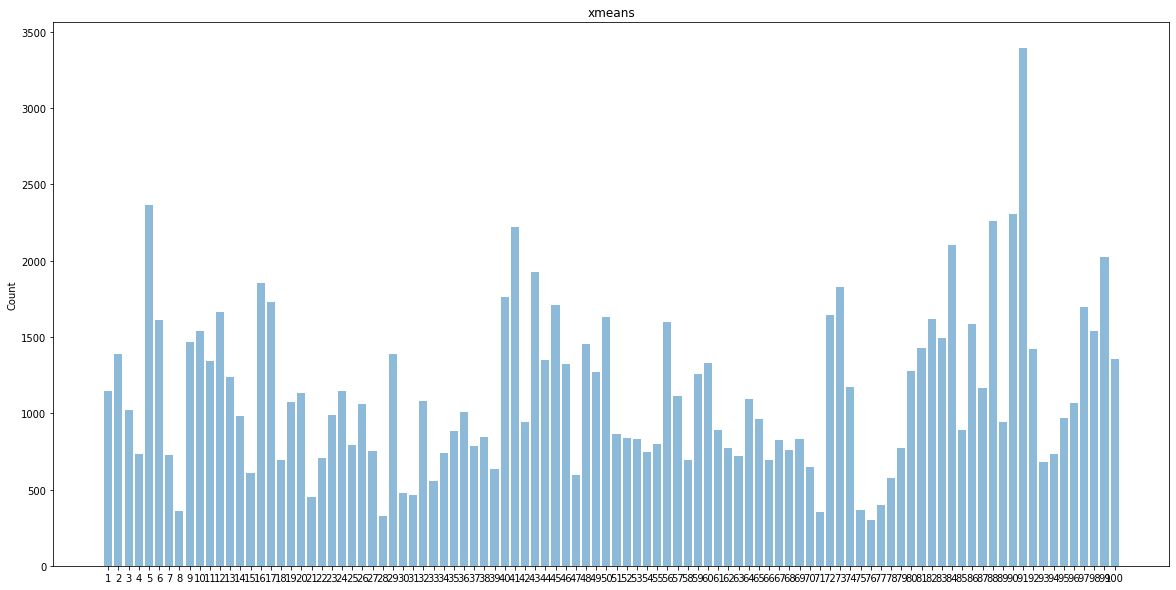

In [18]:
number_of_clusters = 100
clusters_all, centers_all = xmeans_clustering(embeddings_all, number_of_clusters)

In [19]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_all, cleaned_texts_all, items_to_show_per_cluster)



Cluster No: 0	 Count: [1149]

103 i have two hotels that fit your request one is cheap and the other is expensive what is your price range
126 pick the best one and please give price and train id
167 i have several available what is your price range
173 there are 11 available would you like to further search by price range and number of stars
175 i have found 9 guesthouses fitting this criteria do you have a preference on price or stars
361 their price range is expensive and the postcode is cb58pa are you sure that is all you needed
415 certainly and you have 9 choices in italian cuisine do you have a price range in mind
421 unfortunately i do nt show anything in the north that is expensive can i try another area or price range for you
599 i have several options for you in the center of town do you have a price range in mind
725 there are six guesthouses in the east do you have a preference on price
861 i have several options do you prefer a certain price range so that we can narrow 

If you want to find similar clusters of a specific cluster(s), pass the clusters as a list after theshold.

 Example-


```
threshold = 0.8

find_similar_clusters(centers_all, threshold, [1,5,7,45])
```



In [20]:
threshold = 0.8

find_similar_clusters(centers_all, threshold)


Clusters Similar with 4 :
5 0.8608873257249505
55 0.8479814645978657

Clusters Similar with 5 :
4 0.8608873257249505
28 0.8289828661982058

Clusters Similar with 10 :
11 0.8391165099431422

Clusters Similar with 11 :
10 0.8391165099431422

Clusters Similar with 12 :
13 0.8665828372952865
14 0.8202148735808505

Clusters Similar with 13 :
12 0.8665828372952865
34 0.8488317219973083

Clusters Similar with 14 :
12 0.8202148735808505

Clusters Similar with 16 :
18 0.8047510927260515

Clusters Similar with 17 :
18 0.8086826618957215

Clusters Similar with 18 :
16 0.8047510927260515
17 0.8086826618957215

Clusters Similar with 28 :
5 0.8289828661982058

Clusters Similar with 31 :
32 0.8106142669355014
34 0.8173426178240868

Clusters Similar with 32 :
31 0.8106142669355014

Clusters Similar with 34 :
13 0.8488317219973083
31 0.8173426178240868

Clusters Similar with 40 :
42 0.8256464460324863

Clusters Similar with 42 :
40 0.8256464460324863

Clusters Similar with 55 :
4 0.8479814645978657
56 

# USER utterances only

* here I extracted and clustered only the utterances of USER. 

In [21]:
path="train"

cleaned_texts_user = get_cleaned_texted(f"MultiWOZ-Clustering/{path}", ["USER"])

embeddings_user = embed(cleaned_texts_user)

In [19]:
test_utterances = ["what day were you looking to travel", "i want to leave on tuesday", "thank you", "what day were you planning to travel" ]

show_top_5_similar_embeddings(embeddings_user, cleaned_texts_user, test_utterances)

Utterance: what day were you looking to travel
Top 5: 
0.5698370933532715 i would like to travel on monday
0.5740617513656616 what is the travel time for that trip
0.5990920066833496 what day was it booked for sunday or wednesday
0.5991958379745483 monday is the day i plan to travel
0.6330306529998779 what day would you like me to book a room

Utterance: i want to leave on tuesday
Top 5: 
0.930736780166626 i want to leave on monday
0.9417169094085693 i want to leave on thursday
0.9485501646995544 i want to leave on wednesday
0.954721987247467 i need to leave on tuesday
0.9582715034484863 i would like to leave on tuesday

Utterance: thank you
Top 5: 
0.8540490865707397 thanks so much
0.8570412993431091 thank you please
0.8591446280479431 thank you very much
0.8615784645080566 thank you so much
0.9453492164611816 thanks

Utterance: what day were you planning to travel
Top 5: 
0.5562748312950134 i am planning to travel on thursday
0.5699248909950256 what is the travel time for that trip
0

Total WCE: 27347.102931918987
Total Cluster: 75 
Total count of uttarance in Clusters:56776


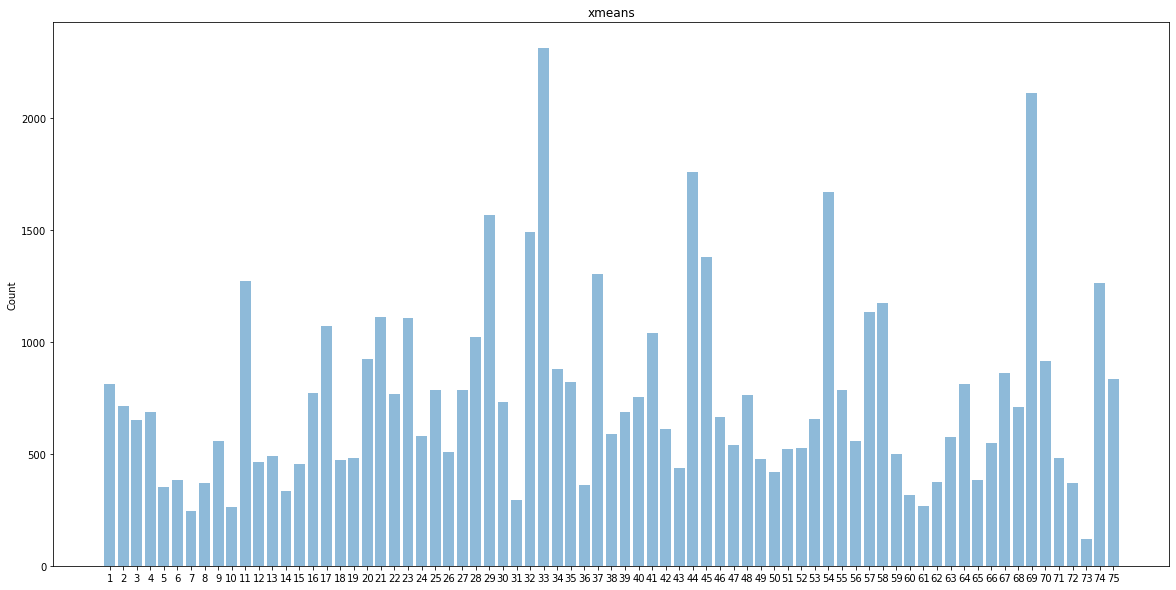

In [22]:
number_of_clusters = 75 
clusters_user, centers_user = xmeans_clustering(embeddings_user, number_of_clusters)

In [23]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_user, cleaned_texts_user, items_to_show_per_cluster)



Cluster No: 0	 Count: [810]

4 perfect can you book it for 5 people on the same day at 1630
10 i do nt care about the cuisine would you book a table for 4 people at 1600 on wednesday
113 zizzi please can you book me for 6 people on saturday at 1615
130 can you see which ones have availability sunday at 1915 for 2 people
133 i d like to reserve a table for 7 on thursday at 1115 are you able to book that for me please
157 it does nt matter what area can you book a table for 2 people at 1100 on wednesday
200 i will try the curry prince can you book a table for 4 people on monday at 1730
254 i d like to book a table for two around 1945 on wednesday
411 that sounds right could you reserve a table for 6 at 1800 on friday
470 sounds great can you reserve us a table same 2 people and on the same day we d like to eat at 1700
515 can you book it for me for 3 people at 1400 on wednesday
627 that works for me can you reserve a table for 3 people on sunday at 4 pm
683 yes i would like to book a t

In [31]:
threshold = 0.8
find_similar_clusters(centers_user, threshold)


Clusters Similar with 0 :
1 0.8515944578828699
2 0.8176883934701992

Clusters Similar with 1 :
0 0.8515944578828699

Clusters Similar with 2 :
0 0.8176883934701992

Clusters Similar with 9 :
10 0.8087157077726324

Clusters Similar with 10 :
9 0.8087157077726324

Clusters Similar with 11 :
14 0.8017868674601791

Clusters Similar with 14 :
11 0.8017868674601791

Clusters Similar with 15 :
16 0.8460537352311135

Clusters Similar with 16 :
15 0.8460537352311135
17 0.8043783673335582

Clusters Similar with 17 :
16 0.8043783673335582
18 0.8887015227470165

Clusters Similar with 18 :
17 0.8887015227470165

Clusters Similar with 19 :
20 0.8150229098894832

Clusters Similar with 20 :
19 0.8150229098894832
21 0.8056236413786247
22 0.8323796642859544

Clusters Similar with 21 :
20 0.8056236413786247
22 0.930676398873604
25 0.8086343434197288
53 0.8373962382028531

Clusters Similar with 22 :
20 0.8323796642859544
21 0.930676398873604
53 0.806991323337178

Clusters Similar with 25 :
21 0.8086343434

# system utterances only

In [25]:
path="train"

cleaned_texts_system = get_cleaned_texted(f"MultiWOZ-Clustering/{path}", ["SYSTEM"])

embeddings_system = embed(cleaned_texts_system)

In [21]:
test_utterances = ["what day were you looking to travel", "i want to leave on tuesday", "thank you", "what day were you planning to travel" ]

show_top_5_similar_embeddings(embeddings_system, cleaned_texts_system, test_utterances)

Utterance: what day were you looking to travel
Top 5: 
0.9205324649810791 what day were you planning to travel
0.9287928938865662 what day did you want to travel
0.9298130869865417 what day are you wanting to travel
0.9453542828559875 what day are you looking to travel
0.9466931819915771 what day were you wanting to travel on

Utterance: i want to leave on tuesday
Top 5: 
0.5513105392456055 may i have a leave time
0.5528232455253601 how many days would like to stay
0.5535703897476196 okay what day would you like to leave
0.558781623840332 ok what day would you like to leave
0.5738750696182251 what day would you like to leave

Utterance: thank you
Top 5: 
0.8209847807884216 thank you take care
0.8529680967330933 thanks very much
0.8591446280479431 thank you very much
0.8615784645080566 thank you so much
0.9453492164611816 thanks

Utterance: what day were you planning to travel
Top 5: 
0.9138695597648621 what day were you wanting to travel on
0.9147047996520996 which day are you planning

Total WCE: 29554.090306737606
Total Cluster: 75 
Total count of uttarance in Clusters:56776


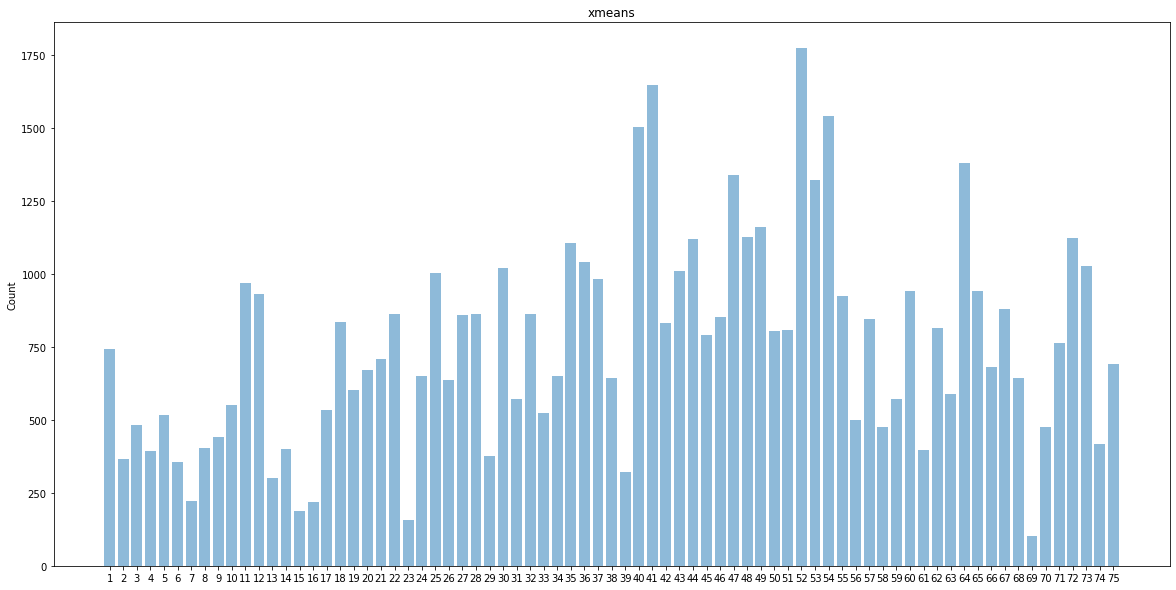

In [26]:
number_of_clusters = 75
clusters_system, centers_system = xmeans_clustering(embeddings_system, number_of_clusters)

In [27]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_system, cleaned_texts_system, items_to_show_per_cluster)



Cluster No: 0	 Count: [742]

73 thank you have a great day
155 ok have a great day
232 okay have a great day
304 i hope you have a wonderful day as well
413 great have a wonderful day
436 thank you as well and have a wonderful day
488 thank you so much have a great day
532 okay you are welcome have a nice day
870 and you have a wonderful day as well
995 ok have a great day
1067 awesome have an awesome day you awesome person
1372 thank you good day to you
1403 okay you have a great day as well
1433 you too sir
1453 thank you
1500 thank you and have a wonderful day
1530 wonderful i hope you have a wonderful rest of the day
1566 okay sounds good
1722 great have a great day
1777 great well thanks for calling you have a good day
2014 thanks you and have a great day
2248 thank you you as well
2321 thank you and have a good day
2517 thank you so much for your patience have a great day
2597 i hope your day gets better
2952 thank you
3016 you re too kind have a nice day
3079 great have a nice

In [30]:
threshold = 0.8
find_similar_clusters(centers_system, threshold)

Clusters Similar with 4 :
45 0.8007534138708626

Clusters Similar with 12 :
13 0.8578546436925767

Clusters Similar with 13 :
12 0.8578546436925767
14 0.8247552825064495

Clusters Similar with 14 :
13 0.8247552825064495
15 0.8962312539367739

Clusters Similar with 15 :
14 0.8962312539367739

Clusters Similar with 18 :
67 0.8207438144933775

Clusters Similar with 24 :
25 0.806157954204538

Clusters Similar with 25 :
24 0.806157954204538

Clusters Similar with 27 :
28 0.8403933063060931
29 0.8434453876909737

Clusters Similar with 28 :
27 0.8403933063060931
29 0.8286561010618144

Clusters Similar with 29 :
27 0.8434453876909737
28 0.8286561010618144

Clusters Similar with 31 :
32 0.8097155995448966

Clusters Similar with 32 :
31 0.8097155995448966

Clusters Similar with 39 :
53 0.8055807495206022

Clusters Similar with 40 :
53 0.8396390504905938

Clusters Similar with 45 :
4 0.8007534138708626
46 0.8126632531083096

Clusters Similar with 46 :
45 0.8126632531083096

Clusters Similar with 